<h1>4. Endogenous Interest Rate Modelling 1 - Vasicek Model, Maximum Likelihood Estimation, Montecarlo Simulation</h1>

This example introduces the Versicek model for modelling short term interest rates. In isolation it is an outdated model but introduces key concepts for more sophiticated models, making it a good place to start when discussing interest rate modelling.<br>

Contents:<br>
4.0) Key Defintions<br>
4.1) Data<br>
4.2) Vasicek Model Tuning Using Maximum Likelihood Estimation<br>
4.3) Using Montecarlo Simulation to Generate Prediction<br><br>

<h2>4.0) Key Definitions</h2>
In such order that later explanations can be made more concisely, there are a few key topics worth defining:<br><br>

Endogenous Models: A model which in which the calculation of parameters is self contained. All variables are defined by thier relationship to other variables in the model and there are no variables treated as given inputs.<br><br>
One-Factor Equilibrium Models: The 'equilibrium' element is that these models attempt to explain the relationship between expected returns and risk taken. The 'one-factor' element is that the relationship is predicated on the value of a single risk factor.<br><br>
Maximum Likelkihood Estimation (MLE): A method used to estimate the parameters of a statistical model. Given a normal distribution of possible outcomes, each set of parameters can be tested to see which parameters configure the model most to have the highest probability of matching the expected distribution. 

<h2>4.1) Data</h2>
The data used in this example was taken from the BoE website ranging from January 1975 to August 2023 with the interval being each policy announcement. Some very basic statistics are computed as a form of exploratory analysis.

In [61]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from scipy.stats import norm

data = pd.read_csv('/Users/quintonaguilera/Desktop/modelling_utilities/Bank Rate history and data Bank of England Database.csv')
data = data.reindex(index=data.index[::-1])
min_rate = data['Rate'].min()
max_rate = data['Rate'].max()
ari_mean = data['Rate'].mean()
ari_stdv = data['Rate'].std()
print('Min: ', min_rate)
print('Max: ', max_rate)
print('Arithmetic Mean: ', ari_mean)
print('Arithmetic Std:', ari_stdv)
data = data.dropna()
data

Min:  0.1
Max:  17.0
Arithmetic Mean:  9.042579365079366
Arithmetic Std: 3.7659215384174862


,Date Changed,Rate
251,20 Jan 75,11.25
250,27 Jan 75,11.00
249,10 Feb 75,10.75
248,17 Feb 75,10.50
247,10 Mar 75,10.25
...,...,...
4,02 Feb 23,4.00
3,23 Mar 23,4.25
2,11 May 23,4.50
1,22 Jun 23,5.00


<h2>Vasicek Model</h2>
The Vasicek model is an endogenous, or one factor equilibrium model for forecasting the interest rate with its primary assumption being that the interest rate is mean reverting, accounting for random shocks. Invented in the 70's, it is rarely if ever used on its own as it is quite primitive compared to later models, but it represents a good starting point for thinking about interest rate modelling. The formula is as follows:

$$dr_t = \theta (\kappa - r_t) \, dt + \sigma \, dW_t$$

<br>
Where dr_t is the change in the interest rate r at time t. Theta is the reversion level (long term average), sigma is the volatility, and W_t is the Wiener process, brownian motion, or any other method of representing a random shock. We will now use this model to forecast the BoE policy rate, configuring parameters using MLE. 
<br>

In [62]:
def vasicek_likelihood(theta, kappa, sigma, interest_rates):

    log_likelihood = 0 # only relative values are important, so starting point is irrelevant
    
    # See formula
    variance = sigma**2 * (1 - np.exp(-2 * kappa)) # Calculate variance accounting for mean reversion
    
    for i in range(1, len(interest_rates)):

        mean = theta + (interest_rates[i-1] - theta) * np.exp(-kappa) # Of the likelihood distribution
        std_dev = np.sqrt(variance)
        
        # log-likelihood contribution
        log_likelihood = log_likelihood + norm.logpdf(interest_rates[i], loc=mean, scale=std_dev)
        
    return log_likelihood



In [63]:
# Take care as this cell can take a long time to run. 

parameter_space = {'theta': [i / 2 for i in range(1, 33)], # 0.5 to 16 in 0.5 increments
                   'kappa': [0.1, 0.125, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3], # Hand selected range
                   'sigma': [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]} # Hand selected range

grd_srch = list(ParameterGrid(parameter_space))

model_results = []

for params in tqdm(grd_srch):
    log_likelihood = vasicek_likelihood(params['theta'], params['kappa'], params['sigma'], data['Rate'])
    temp_result = {'params':params, 'log_likelihood':log_likelihood}
    model_results.append(temp_result)
    
result_df = pd.DataFrame(model_results)
best_model = result_df.iloc[result_df['log_likelihood'].idxmax()]
best_model

100%|██████████| 3840/3840 [02:03<00:00, 31.12it/s]


params            {'kappa': 0.1, 'sigma': 2, 'theta': 9.5}
log_likelihood                                 -284.631121
Name: 178, dtype: object

Before inspecting the results, it is worth dwelling on the computational intensity of this approach. I have selected here a modestly sized parameter space as this example is only for demonstration purposes, but when done in "the real world", it will likely demand a significanty larger parameter space so as to encompass all possible values and therefore has the potential to be enormously computationally intensive.<br><br>
Insofar as the results, the most striking aspect is that theta (admittedly also the most straightforward to interpret) is at 9.5. This suggests the reversion level of the interest rate in England is 9.5% - eyewateringly high for someone whose first economic memory is 2008.<br><br>
This is a good time to reiterate that the Vasicek model is a good strating place for thinking about interest rate modelling, but ultimately rather limited in its applications. From 2008 until 2021, trading under the pretense that the interest rate would be mean reverting to 9.5% at a speed of 10bp per month would have seen you lose huge amounts of money.<br><br>
Methodological evaluation aside, how would you use the produced parameters to forecast the interest rate using the Vasicek model? One potential answer would be to use a montecarlo appraoch. <br><br>
Given the configured parameters, we can choose to generate a number of simulated paths by randomly choosing shock values (W_t in the formula above) and forecasting the interest rate at subsequent timesteps. It is then possible to average the simulations to generate a forecast. In this example, we will look to estimate the interest rate 2 years into the future over 20 simulations and then average the results. 

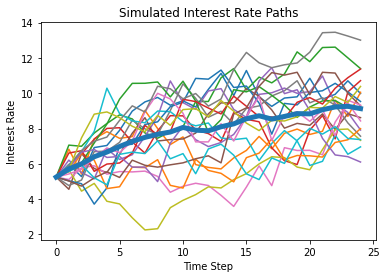

In [73]:
# From result above
theta = 9.5
kappa = 0.1
sigma = 2

time_horizon = 24
num_simulations = 20

# Initialize arrays to store simulated paths
simulated_paths = []

for _ in range(num_simulations):
    
    random_shocks = np.random.normal(size=time_horizon) # Random value by which sigma will be multiplied

    current_rate = data['Rate'].iloc[-1] # most recent rate in the dataset
    path = [current_rate]

    for shock in random_shocks:
        # Vasicek model equation
        next_rate = theta+(current_rate-theta)*np.exp(-kappa)+sigma*np.sqrt(1-np.exp(-2*kappa))*shock
        current_rate = next_rate
        path.append(current_rate)

    simulated_paths.append(path)


for path in simulated_paths:
    plt.plot(path)
    
average = np.mean(simulated_paths, axis=0) 
plt.plot(average, linewidth=5)

plt.xlabel('Time Step')
plt.ylabel('Interest Rate')
plt.title('Simulated Interest Rate Paths')

plt.show()


With the thick line representing the average of the 20 simulations, we can see that the interest rate is predicted to generally tend towards the theta value (9.5). Of course, anyone with even moderate knowledge of the narratives surrounding the trajectory of the BoE's policy rate knows that this is exceedingly unlikely. This dislocation between actual market expectations and the output of the model stems from a) the oversimplified, potentially even incorrect assumtion that that interest rate is generally mean reverting, and b) should the model assumption be correct per market regime, the model has been trained on data spanning multiple regimes that no longer contain information useful for predeicting the current or proceeding regime. <br><br>
While on the grounds of usability the model has been a failure, changing the training data to make the model more realistic is beyond the objective of this example. Here I have demonstrated a basic interest rate model that provides a good theorhetical starting place to explore more sophisticated approaches. 